In [1]:
from dask.distributed import Client, wait
from dask import delayed, persist
import dask.array as da

from functions import cholesky_tsqr, indirect_tsqr, direct_tsqr
import numpy as np

import gc

The condition number of a matrix with respect to the $L^2$-norm is defined as the ratio of its largest to smallest singular value:
$$\kappa(A)=\frac{\sigma_{\text{max}}(A)}{\sigma_{\text{min}}(A)}$$
By prescribing singular values and applying the singular value decomposition (SVD), we can construct an ill-conditioned matrix.

In [2]:
def generate_ill_conditioned(shape : tuple, cond : float) -> np.ndarray:
    ''' 
    Generate an ill-conditioned matrix of given shape and condition number.
    
    Parameters:
    -----------
    shape : tuple
        Shape of the matrix to be generated (m, n).
    cond : float
        Condition number of the matrix.

    Returns:
    --------
    np.ndarray
        An ill-conditioned matrix of shape (m, n) with the specified condition number.
    '''
    n, m = shape
    k = min(m, n)

    s = np.linspace(1, 1/cond, k)

    U, _ = np.linalg.qr(np.random.randn(m,m))
    V, _ = np.linalg.qr(np.random.randn(n,n))

    S = np.zeros((m,n))
    np.fill_diagonal(S, s)
    return U @ S @ V

In [63]:
N_WORKERS = 3
THREADS_PER_WORKER = 1
MEMORY_PER_WORKER = "4GB"
client = Client(
    n_workers=N_WORKERS,
    threads_per_worker=THREADS_PER_WORKER,
    memory_limit=MEMORY_PER_WORKER,
)

print(f"DASK Client with {N_WORKERS} workers ({THREADS_PER_WORKER} threads, {MEMORY_PER_WORKER} memory)")
print("Dashboard:", client.dashboard_link)

/home/miotto/miniconda3/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37431 instead
  warnings.warn(


DASK Client with 3 workers (1 threads, 4GB memory)
Dashboard: http://127.0.0.1:37431/status


In [37]:
n, m = 4, 1_000   # Fixed matrix shape
cond = np.logspace(0, 8, 10, base=10.0)    # Condition numbers to test

results = {
    "Cholesky": (cholesky_tsqr, []),
    "Indirect": (indirect_tsqr, []),
    "Direct": (direct_tsqr, []),
}

for c in cond:
    print(f"Condition number: {c:.1e}")
    # Creation of a random ill-conditioned array inside the
    # workers, subdivided evenly in N_WORKERS chunks.
    A = generate_ill_conditioned((n, m), c)
    chunks = [m // N_WORKERS for _ in range(N_WORKERS-1)]
    chunks.append(m - sum(chunks))
    X_da = da.from_array(A, chunks=(chunks, n))
    X_da.persist()

    for name, (algorithm, _) in results.items():
        print(f"  {name}", end=" ")
        Q, _ = algorithm(X_da)
        Qt = delayed(np.transpose)(Q)
        _tmp = delayed(np.linalg.matmul)(Qt, Q)
        _tmp = _tmp.compute()   # _tmp is now small (n x n)
        wait(_tmp)
        
        # Compute the orthogonality error
        orthogonality = np.linalg.norm(_tmp - np.eye(n))
        print(f"({orthogonality:.1e})")
        results[name][1].append(orthogonality)
        
        # Clean memory from previous computations
        client.cancel(Q)
    
    print()
    client.cancel(X_da)
    gc.collect()
    client.run(gc.collect)


Condition number: 1.0e+00
  Cholesky (2.5e-16)
  Indirect (6.7e-16)
  Direct (4.1e-16)

Condition number: 7.7e+00
  Cholesky (5.9e+00)
  Indirect (2.0e-15)
  Direct (9.2e-16)

Condition number: 6.0e+01
  Cholesky (1.3e+03)
  Indirect (3.5e-15)
  Direct (6.8e-16)

Condition number: 4.6e+02
  Cholesky (9.9e+04)
  Indirect (1.7e-13)
  Direct (7.7e-16)

Condition number: 3.6e+03
  Cholesky (1.6e+06)
  Indirect (2.7e-13)
  Direct (5.5e-16)

Condition number: 2.8e+04
  Cholesky (3.2e+08)
  Indirect (2.3e-12)
  Direct (7.1e-16)

Condition number: 2.2e+05
  Cholesky (2.8e+10)
  Indirect (1.7e-11)
  Direct (5.5e-16)

Condition number: 1.7e+06
  Cholesky (6.3e+11)
  Indirect (1.7e-10)
  Direct (8.6e-16)

Condition number: 1.3e+07
  Cholesky (4.9e+13)
  Indirect (9.0e-10)
  Direct (3.4e-16)

Condition number: 1.0e+08
  Cholesky (7.3e+15)
  Indirect (2.5e-09)
  Direct (5.1e-16)



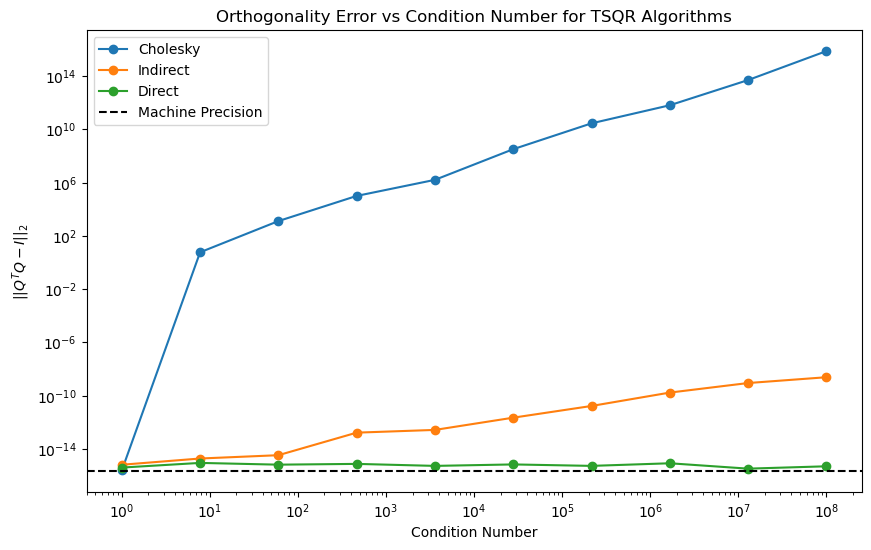

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for name, (_, orthogonalities) in results.items():
    plt.plot(cond, orthogonalities, marker='o', label=name)
plt.axhline(y=np.finfo(float).eps, color='k', linestyle='--', label='Machine Precision')
plt.xlabel('Condition Number')
plt.ylabel('$||Q^T Q - I||_2$')
plt.title('Orthogonality Error vs Condition Number for TSQR Algorithms')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

## Iterative correction
In the ill-conditioned regime—such as when using Indirect or Cholesky TSQR decomposition—a single iterative refinement step is often sufficient to improve the stability of the algorithm (Benson et al.). In both the Cholesky and Indirect approaches, we compute $Q=AR^{-1}$, but if $A$ is ill-conditioned, the resulting $Q$ may not be exactly orthogonal. Let $Q_0$ denote our initial approximation of $Q$, and define the orthogonality error:
$$E=1-Q_0^T Q_0$$
We can write the exact orthogonal $Q$ as $Q=Q_0+\Delta Q$. Because $Q^TQ=1$, and expanding $Q=Q_0+\Delta Q$ and expand the orthogonality condition $Q^T Q=1$ to first order in $\Delta Q_0$, we get $E\simeq Q_0^T \Delta Q+\Delta Q^T Q_0$. Assuming the deviation $\Delta Q$ is linear in $Q_0$ (i.e. $\Delta Q=Q_0 X$), and using $Q_0^TQ_0\approx 1$, we obtain $E\approx X+X^T$. Since $E$ is symmetric, a solution is $X=E/2$, yelding:
$$Q\approx Q_0+\frac{1}{2}Q_0E=Q_0\left(1+\frac{1}{2}E\right)$$
For matrices with high condition number, the Cholesky algorithm with a step of iterative correction alone performs poorly, whereas the Indirect method achieves results comparable to the Direct. To further improve the Cholesky method, we can apply multiple iterative correction steps and introduce an adaptive step size $\alpha$. 
$$Q\leftarrow Q+\alpha QE$$

In [152]:
instable_algorithm = {
    "Cholesky IR": (cholesky_tsqr, []),
    "Indirect IR": (indirect_tsqr, []),
}


def iterative_refinement(Q : np.ndarray, n_iter : int = 1) -> np.ndarray:
    ''' 
    Perform iterative refinement to improve the orthogonality of matrix Q.

    Parameters:
    ---------
    Q : np.ndarray
        Initial near-orthogonal matrix to be refined.
    n_iter : int
        Number of iterative refinement steps to perform.

    Returns:
    --------
    np.ndarray
        Refined orthogonal matrix.
    '''
    for _ in range(n_iter):
        E = np.eye(n) - Q.T @ Q
        error_norm = np.linalg.norm(E)
        # Adaptive step size
        alpha = min(0.5, 1.0 / (1.0 + error_norm))
        Q = Q + alpha * Q @ E
    return Q


for c in cond:
    print(f"Condition number: {c:.1e}")
    # Creation of a random ill-conditioned array inside the
    # workers, subdivided evenly in N_WORKERS chunks.
    A = generate_ill_conditioned((n, m), c)
    chunks = [m // N_WORKERS for _ in range(N_WORKERS-1)]
    chunks.append(m - sum(chunks))
    X_da = da.from_array(A, chunks=(chunks, n))
    X_da.persist()

    for name, (algorithm, _) in instable_algorithm.items():
        print(f"  {name}", end=" ") 
        Q, R = algorithm(X_da)
        Q = Q.compute()
        
        # Apply iterative refinement
        Q = iterative_refinement(Q, n_iter=60)

        # Compute the orthogonality error
        orthogonality = np.linalg.norm(Q.T @ Q - np.eye(n))
        print(f"({orthogonality:.1e})")
        instable_algorithm[name][1].append(orthogonality)
        
        # Clean memory from previous computations
        client.cancel(Q)
    
    print()
    client.cancel(X_da)
    gc.collect()
    client.run(gc.collect)

Condition number: 1.0e+00
  Cholesky IR (1.1e-16)
  Indirect IR (2.2e-16)

Condition number: 7.7e+00
  Cholesky IR (8.0e-18)
  Indirect IR (2.2e-16)

Condition number: 6.0e+01
  Cholesky IR (2.2e-16)
  Indirect IR (3.1e-16)

Condition number: 4.6e+02
  Cholesky IR (6.2e-18)
  Indirect IR (3.7e-18)

Condition number: 3.6e+03
  Cholesky IR (1.1e-16)
  Indirect IR (5.0e-18)

Condition number: 2.8e+04
  Cholesky IR (7.9e-18)
  Indirect IR (2.2e-16)

Condition number: 2.2e+05
  Cholesky IR (1.1e-16)
  Indirect IR (1.1e-16)

Condition number: 1.7e+06
  Cholesky IR (8.5e-18)
  Indirect IR (2.2e-16)

Condition number: 1.3e+07
  Cholesky IR (2.2e-16)
  Indirect IR (2.2e-16)

Condition number: 1.0e+08
  Cholesky IR (1.1e-16)
  Indirect IR (2.2e-16)



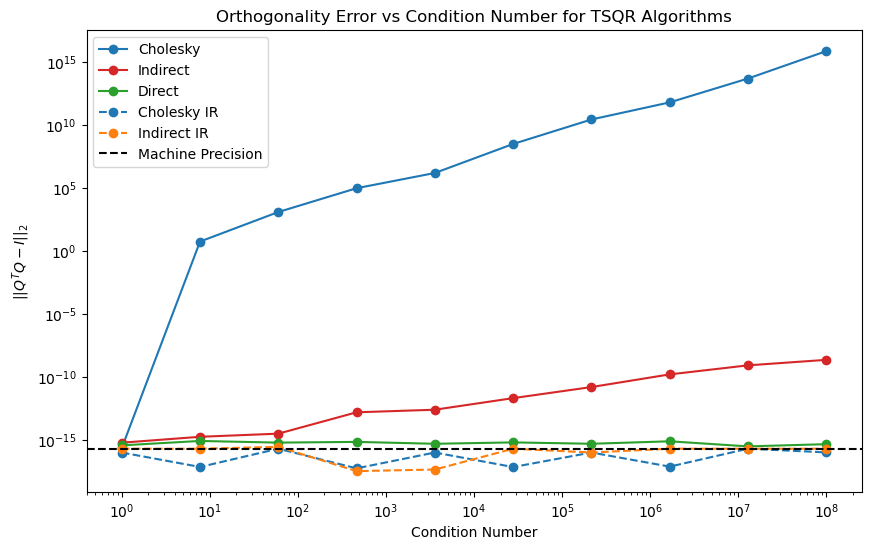

In [153]:
import matplotlib.pyplot as plt

palette = {
    "Cholesky": "tab:blue",
    "Indirect": "tab:red",
    "Direct": "tab:green",
}


plt.figure(figsize=(10, 6))
for name, (_, orthogonalities) in results.items():
    plt.plot(cond, orthogonalities, marker='o', label=name, color=palette[name])
for name, (_, orthogonalities) in instable_algorithm.items():
    plt.plot(cond, orthogonalities, marker='o', label=name, linestyle='--')
plt.axhline(y=np.finfo(float).eps, color='k', linestyle='--', label='Machine Precision')
plt.xlabel('Condition Number')
plt.ylabel('$||Q^T Q - I||_2$')
plt.title('Orthogonality Error vs Condition Number for TSQR Algorithms')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [62]:
client.restart()